# Instacart dataset EDA 프로젝트

<img src="instacartl2.png" alt="Drawing" style="width: 1000px"/>
<img src="instacart1.jpg" alt="Drawing" style="width: 500px"/>


In [3]:
from IPython.display import Image

# 회사 개요
- **"식품계의 우버"라 불리는 미국의 신선식품 배달 서비스 스타트업. (ex : 한국의 B마트)**
- **월마트, 세이프웨이, 코스트코등 대형마트 부터 지역 슈퍼마켓**
- **설립 2년 만에 유니콘**
- **8년간 16억달러(약 1조8800억원) 투자유치**

# Dataset 개요
> - **총 유저수 : 206,209(약 20만 명)**
> - **판매된 총 제품수 : 33,819,106(약 3380만 건)**
> - **품목 수 : 49,688(약 5만 종)**
> - **총 주문량 : 3,421,083(약 340만 건)**
> - **품목당 평균 판매 횟수 : 약 680건**
> - **유저 1명당 평균 주문 횟수 : 16.5회**
> - **재구매율 : 약 59%**

## 선택한 이유 :
> - **데이터의 양**
> - **실제 생활과 밀접**
> - **예측 모델**

## 데이터 로드

In [4]:
df_orders = pd.read_csv("origin/orders.csv")
df_order_products = pd.read_csv("origin/merged_order_products.csv")
df_ptoducts = pd.read_csv("origin/products.csv")
df_aisles = pd.read_csv("origin/aisles.csv")
df_departments = pd.read_csv("origin/departments.csv")
product_plus_aisle = pd.merge(df_ptoducts, df_aisles)
product_plus_aisle_plus_departments = pd.merge(
    product_plus_aisle, df_departments)
product_plus_aisle_plus_departments_plus_order_products = pd.merge(
    product_plus_aisle_plus_departments, df_order_products)
raw_data = pd.merge(
    product_plus_aisle_plus_departments_plus_order_products, df_orders)

##  raw_data 컬럼

### 시간관련
- order_dow: 주문한 요일
- order_hour_of_day: 주문한 시간


### 제품관련
- product_id: 제품 ID
- product_name: 제품 이름
- aisle_id: 소분류 ID
- aisle: 소분류 이름
- department_id: 대분류 ID
- department: 대분류 이름


### 주문관련
- user_id: 고객 ID
- order_id: 주문 ID
- add_to_cart_order: 각 제품이 장바구니에 추가 된 순서
- reordered: 사용자가 해당 제품을 과거에 주문한 경우 1, 그렇지 않으면 0

### etc
- days_since_prior: 마지막 주문 이후 일 수, 30 일 제한 (NA는 order_number1) 재주문 기간의 텀
- aisle_id : foreign key
- department_id: foreign key
- eval_set: 이 순서가 속하는 평가 세트
- order_number: 이 사용자의 주문 순서 번호 (1 = 첫 번째, n = n 번째)

# 그래서 뭐가 궁금한가?

# 이용자들은 어떤 물건을 재구매할 확률이 높은 걸까?

## 가설 1 : 시간 및 요일등에 따라 품목과 재구매 정도의 차이가 있을것이다.
## 가설 2 :  판매량이 높은 제품이 재구매도 많을 것이다.
## 가설 3 : 장바구니의 첫번째 담은 물건의 재구매의 확률이 높을 것이다.

## 시간 및 요일별 구매 및 재구매 횟수

In [9]:
# 시간,요일 별 구매 횟수
df = pd.pivot_table(raw_data, index=raw_data['order_dow'],
                    columns=raw_data['order_hour_of_day'], aggfunc='count', values='user_id')
df = df / 1000
df = df.astype("int")

# 시간,주 별 재구매 횟수
columns = [	'reordered', 'order_dow', 'order_hour_of_day']
data_time = raw_data[columns]
time_table = data_time.pivot_table(
    index='order_dow', columns='order_hour_of_day',
    values='reordered', aggfunc=sum)

time_table = time_table / 1000
time_table = time_table.astype("int")

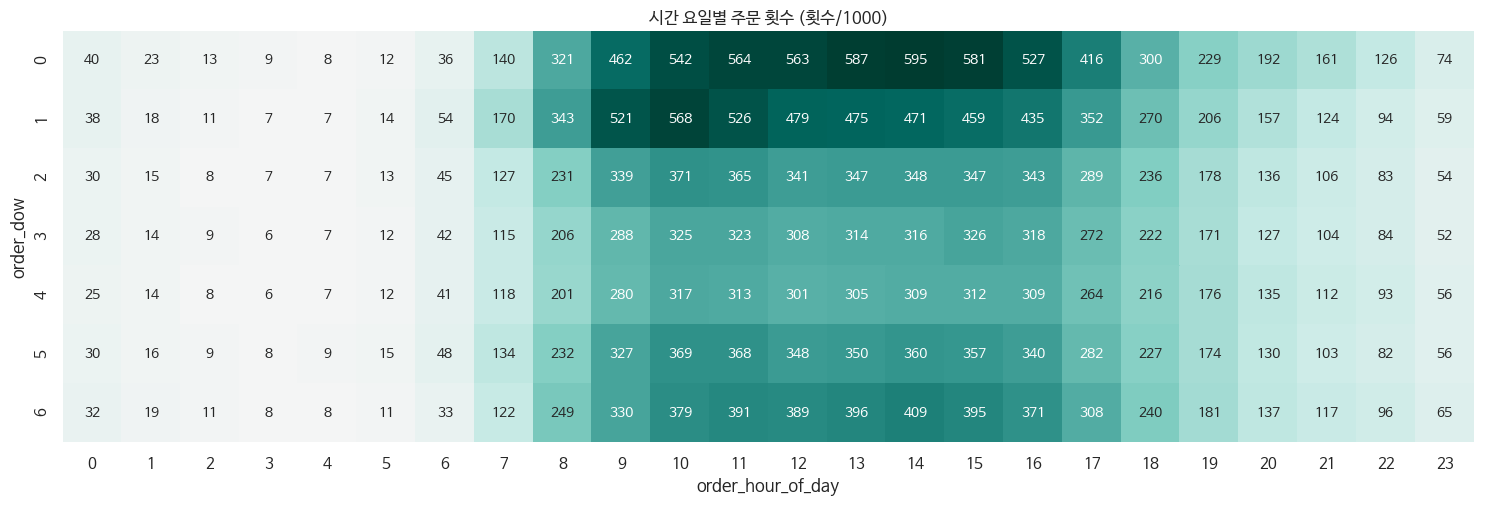

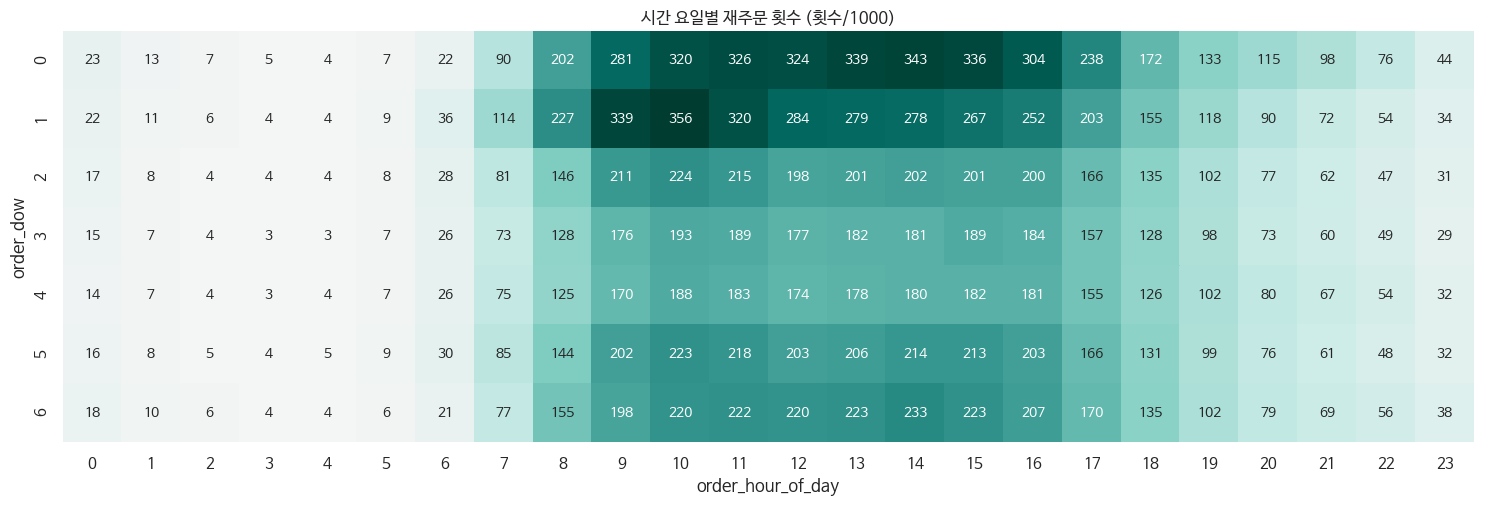

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
ax = plt.axes()
ax.set_title('시간 요일별 주문 횟수 (횟수/1000)')
sns.heatmap(df, cmap="BrBG", center=3, annot=True,
            fmt="d", square=True, cbar=False, ax=ax)
plt.tight_layout()

plt.figure(figsize=(15, 10))
plt.subplot(122)
ax = plt.axes()
ax.set_title('시간 요일별 재주문 횟수 (횟수/1000)')
sns.heatmap(time_table, cmap="BrBG", center=3, annot=True,
            fmt="d", square=True, cbar=False, ax=ax)
plt.tight_layout()
plt.show()

- ### 09시 ~ 17시 사이에 주문이 집중
- ### 토,일요일에 주문이 집중(0,1)
- ### 시간, 요일에 따른 구매횟수와 재주문 횟수는 비슷한 빈도를 보임


### 구매가 가장 많이 일어나는 시간대에 무슨 품목이 많이 팔리는가?

In [309]:
# 요일 별 구매 상품 순위
daily_product = pd.pivot_table(
    raw_data, index=raw_data['product_name'], columns=raw_data['order_dow'], aggfunc='count', values='user_id')

result = []
for i in range(0, 2):
    a = daily_product[i].sort_values(ascending=False)[:10].index
    result.append(a)

daily_product = pd.DataFrame(result)
daily_product['order_dow'] = [0, 1]
daily_product.set_index('order_dow')

,0,1,2,3,4,5,6,7,8,9
order_dow,,,,,,,,,,
0,Banana,Bag of Organic Bananas,Organic Baby Spinach,Organic Strawberries,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries
1,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Organic Raspberries,Organic Whole Milk


In [332]:
# 시간대 별 구매 상품 순위
df = pd.pivot_table(raw_data, index=raw_data['product_name'],
                    columns=raw_data['order_hour_of_day'], aggfunc='count', values='user_id')
result = []
for i in range(9, 17):
    a = df[i].sort_values(ascending=False)[:10].index
    result.append(a)
hourly_product = pd.DataFrame(result)
hourly_product['hour'] = [9, 10, 11, 12, 13, 14, 15, 16]
hourly_product.set_index('hour')
hourly_product

,0,1,2,3,4,5,6,7,8,9,hour
0,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Strawberries,Large Lemon,Organic Raspberries,Organic Whole Milk,9
1,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Strawberries,Limes,Organic Raspberries,10
2,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries,11
3,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries,12
4,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,13
5,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,14
6,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Whole Milk,15
7,Banana,Bag of Organic Bananas,Organic Strawberries,Organic Baby Spinach,Organic Hass Avocado,Organic Avocado,Large Lemon,Limes,Strawberries,Organic Raspberries,16


# 가설 1의 결론:

- ### 토,일요일 낮시간대 (09~17시) 에 바나나(유기농), 딸기, 시금치, 아보카도 등이 많이 팔린다
- ### 요일, 시간별 구매횟수와 재구매 횟수는 비슷한 분포를 보인다.

## 가설 2 :  판매량이 높은 제품이 재구매도 많을 것이다.

## product

In [23]:
# 분석용 데이터 생성
columns = ['product_id', 'reordered', 'product_name']
data_product = raw_data[columns]

# 피봇테이블
product_table = data_product.pivot_table(
    index='product_name', columns='reordered', aggfunc='count', fill_value=0)
columns = ['first_order', 'reorder']
product_table.columns = columns

# 테이블 정리
product_table['product_total'] = product_table['first_order'] + \
    product_table['reorder']
product_table['product_reorder_rate'] = product_table['reorder'] / \
    product_table['product_total'] * 100
product_table.sort_values(by='product_total', ascending=False, inplace=True)
product_table.head()

,first_order,reorder,product_total,product_reorder_rate
product_name,,,,
Banana,76125,415166,491291,84.505110
Bag of Organic Bananas,65655,329275,394930,83.375535
Organic Strawberries,61129,214448,275577,77.817815
Organic Baby Spinach,56766,194939,251705,77.447409
Organic Hass Avocado,44704,176173,220877,79.760681


In [17]:
# 몇개 이상의 제품이 팔려야 많이 팔린것인가?
def numoforder(n):
     return product_table[product_table['product_total'] >= n]
n = 1000
print("{}개 이상 팔린 제품의 총 개수:".format(n),numoforder(n)['product_total'].sum())
print("총 팔린 제품의 개수:",product_table['product_total'].sum())
print(f'{n}개 이상 팔리면 전체 품목에서',round(numoforder(n)['product_total'].sum() / product_table['product_total'].sum() * 100,2),'%를 차지합니다.' )

1000개 이상 팔린 제품의 총 개수: 27793456
총 팔린 제품의 개수: 33819106
1000개 이상 팔리면 전체 품목에서 82.18 %를 차지합니다.


In [18]:
product_table = product_table[product_table['product_total'] >= 1000]
product_table.sort_values(by='product_name', ascending=True, inplace=True)

## 두 데이터의 단위의 차이가 크기 때문에 스피어만 상관계수를 이용

In [19]:
# 스피어만 상관계수
print("스피어만 상관계수", sp.stats.spearmanr(
    product_table['product_total'], product_table['product_reorder_rate'])[0])
# 피어슨 상관계수
print("피어슨 상관계수", np.corrcoef(
    product_table['product_total'], product_table['product_reorder_rate'])[0, 1])

스피어만 상관계수 0.2466400096071126
피어슨 상관계수 0.17896402778787496


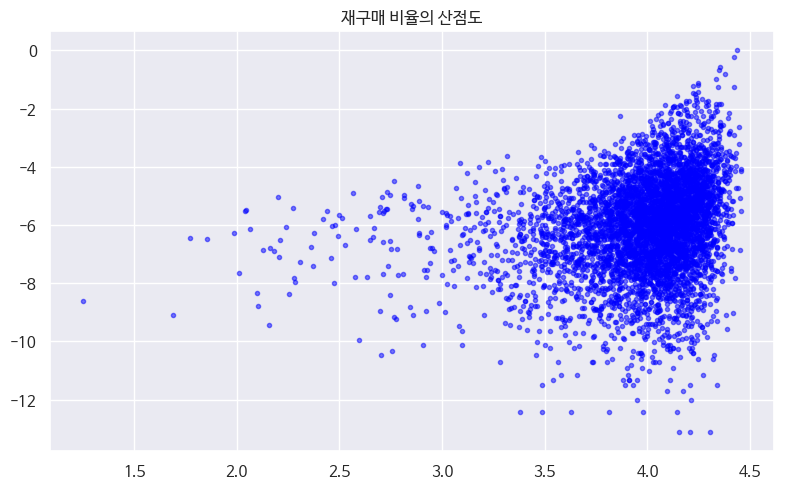

In [21]:
# 산점도
from sklearn import preprocessing
plt.plot(np.log(product_table['product_reorder_rate']),
         np.log(preprocessing.minmax_scale(product_table['product_total'])),
         linestyle='none',
         marker='o',
         markersize=3,
         color='blue',
         alpha=0.5)
plt.title("재구매 비율의 산점도")
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

## Aisle

In [206]:
# 분석용 데이터 프레임 생성
columns = ['aisle_id', 'reordered', 'aisle']
data_aisle = raw_data[columns]

# 피봇테이블 생성
aisle_table = data_aisle.pivot_table(
    index='aisle', columns='reordered', aggfunc='count')
columns = ['first_order', 'reorder']
aisle_table.columns = columns

# 피봇테이블 정리
aisle_table['aisle_total'] = aisle_table['first_order'] + \
    aisle_table['reorder']
aisle_table['aisle_reorder_rate'] = aisle_table['reorder'] / \
    aisle_table['aisle_total'] * 100
aisle_table.sort_values(by='aisle', ascending=False, inplace=True)
aisle_table.head()

,first_order,reorder,aisle_total,aisle_reorder_rate
aisle,,,,
yogurt,472626,1034957,1507583,68.650084
white wines,11648,19998,31646,63.192821
water seltzer sparkling water,237162,640988,878150,72.992997
vitamins supplements,32347,14681,47028,31.217573
trash bags liners,22345,11357,33702,33.698297


In [199]:
# 스피어만 상관계수
print("스피어만 상관계수", sp.stats.spearmanr(
    aisle_table['aisle_total'], aisle_table['aisle_reorder_rate'])[0])
# 피어슨 상관계수
print("피어슨 상관계수", np.corrcoef(
    aisle_table['aisle_total'], aisle_table['aisle_reorder_rate'])[0, 1])

스피어만 상관계수 0.5708126036484247
피어슨 상관계수 0.38006683048455375


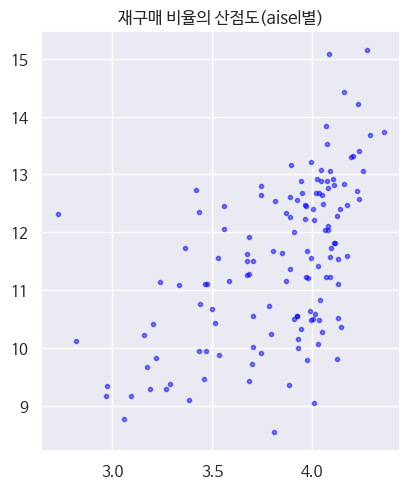

In [364]:
# 산점도
plt.subplot(121)
plt.plot(np.log(aisle_table['aisle_reorder_rate']),
         np.log(aisle_table['aisle_total']),  
         linestyle='none', 
         marker='o', 
         markersize=3,
         color='blue', 
         alpha=0.5)
plt.title("재구매 비율의 산점도(aisel별)")
plt.tight_layout()
plt.show()

## 가설 2 결론 : 
- ### 양의 상관계를 보이는것으로 보아, 주문량이 증가하면 재구매율도 같이 높다. 

## 가설 3 : 장바구니의 첫번째 담은 물건의 재구매의 확률이 높을 것이다.

In [29]:
# 분석용 데이터셋 생성
columns = ['order_id', 'product_id', 'add_to_cart_order',
           'reordered', 'days_since_prior_order']
data_cart = raw_data[columns]
data_cart.head(2)

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order
0,1107,1,7,0,7.0
1,1107,46149,6,0,7.0


In [30]:
# 총 주문갯수가 1개인 데이터의 갯수
a = data_cart['order_id'].value_counts() == 1
print(a.sum(), '개')

163593 개


In [31]:
# 전체 주문이 1인 데이터 갯수 전처리
# 전체 주문이 1인 데이터를 데이터 프레임 및 True = 1, False = 0 으로 변환
a = pd.DataFrame(a)
a.replace(False, 0, inplace=True)
# 컬럼명 변환
a.columns = ['first']
# merge용 index 생성
a.reset_index(inplace=True)

In [32]:
# 분석용 데이터 셋과, 전체 주문이 1개인 데이터 merge
data_cart_two_more = data_cart.merge(a, left_on='order_id', right_on='index')

In [33]:
# 전체 주문이 1개인 데이터 삭제
data_cart_two_more[data_cart_two_more['first'] != 1]

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order,index,first
0,1107,1,7,0,7.0,1107,0.0
1,1107,46149,6,0,7.0,1107,0.0
2,1107,9434,2,0,7.0,1107,0.0
3,1107,769,10,0,7.0,1107,0.0
4,1107,12078,9,0,7.0,1107,0.0
...,...,...,...,...,...,...,...
33818867,62363,5161,1,1,5.0,62363,0.0
33818874,1159533,1000,2,1,3.0,1159533,0.0
33818875,1159533,5161,1,1,3.0,1159533,0.0
33818884,3275452,1000,1,1,5.0,3275452,0.0


In [34]:
# 분석에 필요한 컬럼만 재 정렬
data_cart_two_more = data_cart_two_more[['order_id', 'product_id',
                                         'add_to_cart_order', 'reordered', 'days_since_prior_order']]

In [35]:
# 장바구니에 1번째로 담긴 품목만 확인
data_cart_two_more = data_cart_two_more[data_cart_two_more['add_to_cart_order'] == 1]
data_cart_two_more

,order_id,product_id,add_to_cart_order,reordered,days_since_prior_order
12,1107,16797,1,1,7.0
19,5319,19972,1,1,1.0
28,6695,37600,1,1,8.0
50,7540,48907,1,1,7.0
54,9228,45260,1,0,30.0
...,...,...,...,...,...
33819101,2323735,30365,1,1,1.0
33819102,2733396,30365,1,0,0.0
33819103,3152383,30365,1,0,13.0
33819104,31522,48778,1,1,4.0


## 각 주문에서 장바구니에 제일 처음 담은 물품만 남기고 필터링
## 3,346,083 (약 330만)

In [36]:
# 피벗테이블 생성
table_cart = data_cart_two_more.pivot_table(
    index='product_id', columns='reordered', values='add_to_cart_order', aggfunc='count', fill_value=0)
table_cart.reset_index(inplace=True)
table_cart.columns = ['product_id', 'first_order', 'reorder']
# proudct_name을 알기위해 df_ptoducts merge
table_cart_product = table_cart.merge(
    df_ptoducts, left_on='product_id', right_on='product_id')

In [37]:
# 피벗테이블의 컬럼명 정리
table_cart_product = table_cart_product[[
    'product_id', 'product_name', 'first_order', 'reorder']]
# 첫 주문과, 재주문의 총합 (1번째로 장바구니에 추가된 제품들의)
table_cart_product['total'] = table_cart_product['first_order'] + \
    table_cart_product['reorder']
# 1번째로 장바구니에 추가된 제품의 재구매 비율
table_cart_product['reorder_rate'] = table_cart_product['reorder'] / \
    table_cart_product['total'] * 100

## 장바구니에 처음 담긴 물품의 재구매율 상위 5위 비교

In [38]:
# 주문량이 많지 않음
table_cart_product.sort_values(by='reorder_rate', ascending=False).head()

,product_id,product_name,first_order,reorder,total,reorder_rate
36619,43147,"Chardonnay, Oak Knoll District of Napa Valley,...",0,2,2,100.0
40541,47729,"Salami, Rose, Recipe No. 7",0,1,1,100.0
22070,26018,Fruit Chews Superfruit Flavors,0,2,2,100.0
38919,45827,Roasted Seaweed Snack Coconut Oil,0,1,1,100.0
24549,28950,Spry Fresh Fruit Chewing Gum,0,2,2,100.0


## 판매된 제품 수량별 재구매율

In [39]:
# 대표성 확인을 위한 함수 설정
def numofproduct(n):
    return table_cart_product[table_cart_product['total'] >= n].sort_values(by='reorder_rate', ascending=False)

In [40]:
# 100개 이상 팔린 제품의 reorder_rate
n = 100
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].count(), '가지 입니다.')
print(f'{n}개 이상 팔린 제품수의 총합은', numofproduct(n)['total'].sum(), '개 입니다.')
print('장바구니에 1번째로 선택된 제품의 총합은', table_cart_product['total'].sum(), '개 입니다.')
print(f'{n}개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의', round(numofproduct(n)[
      'total'].sum() / table_cart_product['total'].sum() * 100, 2), '% 입니다')

100개 이상 팔린 제품은 4693 가지 입니다.
100개 이상 팔린 제품수의 총합은 2784804 개 입니다.
장바구니에 1번째로 선택된 제품의 총합은 3346083 개 입니다.
100개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의 83.23 % 입니다


In [41]:
# 1000개 이상 팔린 제품의 reorder_rate
n = 1000
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].count(), '가지 입니다.')
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].sum(), '개 입니다.')
print('장바구니에 1번째로 선택된 제품의 총합은', table_cart_product['total'].sum(), '개 입니다.')
print(f'{n}개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의', round(numofproduct(n)[
      'total'].sum() / table_cart_product['total'].sum() * 100, 2), '% 입니다')

1000개 이상 팔린 제품은 484 가지 입니다.
1000개 이상 팔린 제품은 1611806 개 입니다.
장바구니에 1번째로 선택된 제품의 총합은 3346083 개 입니다.
1000개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의 48.17 % 입니다


In [42]:
# 10000개 이상 팔린 제품의 reorder_rate
n = 10000
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].count(), '가지 입니다.')
print(f'{n}개 이상 팔린 제품은', numofproduct(n)['total'].sum(), '개 입니다.')
print('장바구니에 1번째로 선택된 제품의 총합은', table_cart_product['total'].sum(), '개 입니다.')
print(f'{n}개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의', round(numofproduct(n)[
      'total'].sum() / table_cart_product['total'].sum() * 100, 2), '% 입니다')

10000개 이상 팔린 제품은 16 가지 입니다.
10000개 이상 팔린 제품은 454642 개 입니다.
장바구니에 1번째로 선택된 제품의 총합은 3346083 개 입니다.
10000개 이상 팔린 제품은 장바구니에 1번째로 선택된 제품 총합의 13.59 % 입니다


In [43]:
numofproduct(100).head(3)

,product_id,product_name,first_order,reorder,total,reorder_rate
8491,10031,Homestyle Orange Juice,7,140,147,95.238095
14515,17163,Vitamin A & D Fat Free Milk,9,111,120,92.500000
2733,3248,Breakfast Burrito With Potatoes Jack & Cheddar...,9,109,118,92.372881


In [44]:
numofproduct(1000).head(3)

,product_id,product_name,first_order,reorder,total,reorder_rate
38633,45504,Whole Organic Omega 3 Milk,221,2137,2358,90.627651
4679,5514,Organic Homogenized Whole Milk,121,1037,1158,89.550950
4650,5479,Italian Sparkling Mineral Water,745,6214,6959,89.294439


In [45]:
numofproduct(10000).head(3)

,product_id,product_name,first_order,reorder,total,reorder_rate
21084,24852,Banana,13252,102269,115521,88.528493
32824,38689,Organic Reduced Fat Milk,1180,9062,10242,88.478813
11142,13176,Bag of Organic Bananas,10226,72651,82877,87.661233


## 가설 3 결론 : 장바구니에 첫번째로 들어간 제품은 재구매 한 재품일 확률이 높다.

## 가설 1 결론
- ### 요일, 시간별 구매횟수와 재구매 횟수는 비슷한 분포를 보인다.

## 가설 2 결론
- ### 양의 상관계를 보이는것으로 보아, 주문량이 증가하면 재구매율도 같이 높다. 

## 가설 3 결론
- ### 장바구니에 첫번째로 들어간 제품은 재구매 한 재품일 확률이 높다.

# 그래서 이용자들은 어떤 물건을 재구매할 확률이 높은 걸까?


### 재구매율은 시간 및 요일보다, 제품의 주문량이 높고, 장바구니에 첫번째로 들어간 제품일수록 높아진다.

## So what?
> **사업이 발전하려면, 재구매율을 높여야 한다.**

> **이를 위해, 주문량이 높고, 장바구니에 처음들어간 제품을 우선으로 프로모션하고,
유사한 제품을 취급하는 채널들과의 연계를 발전시켜야 한다.**

# 그리고...

- #### 처음 구매한 주문이 약 40%를 차지 한다는건, 취급하는 상점이 증가되거나, 신규유저가 지속적으로 유입되서 새로운 주문이 증가했다고 볼수 있다.
- #### 즉 이 데이터셋이 수집된 기간 동안 사업이 지속적으로 성장했다고도 볼수 있다.


In [24]:
# 처음 구매한 비율
1 - (raw_data["reordered"].sum() / len(raw_data["reordered"]))

0.4099382757190566

# 아쉬운점

- #### 예측 모델을 만들어 봤으면..
- #### barplot 같은 좀더 직관적인 그래프 였으면..
- #### 날짜 데이터가 있었다면..